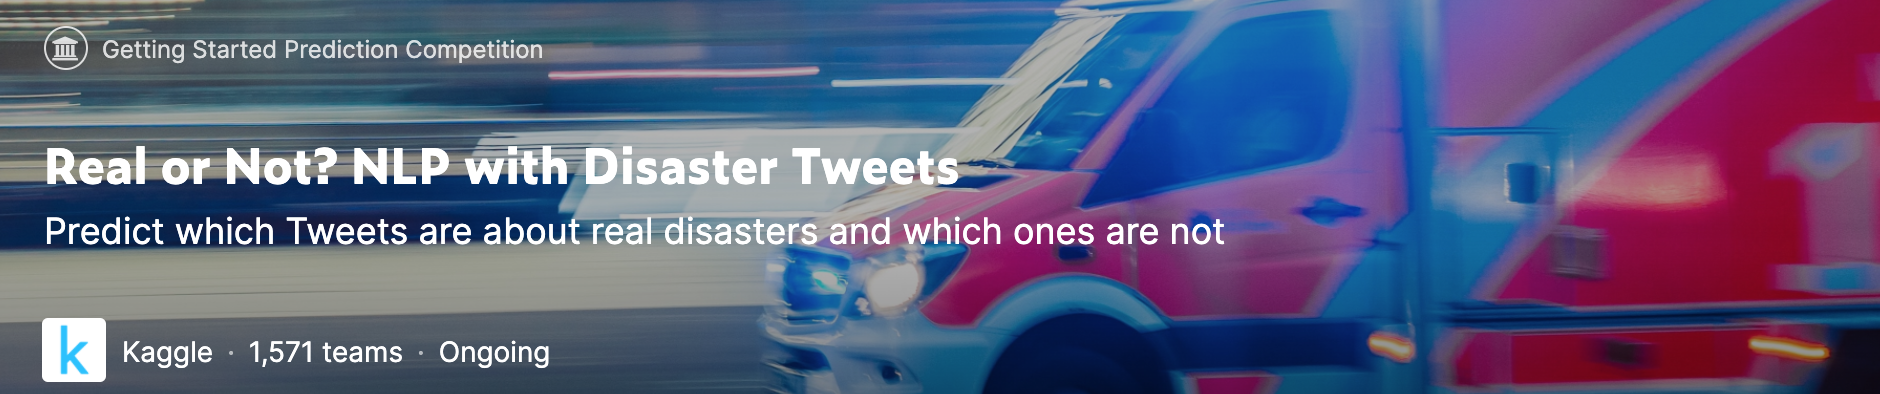

In [ ]:
!wget https://github.com/ravi-ilango/odsc2020_nlp/blob/main/lab1/disaster_data.zip?raw=true -O disaster_data.zip

!unzip disaster_data.zip

In [1]:
# imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

from tqdm import trange

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
% matplotlib inline

Using Theano backend.


In [2]:
model_path = './bert_disaster_detection_state_dict.pth'

### Load data

In [3]:
#
# queries are stored in the variable query_text
# correct intent labels are stored in the variable labels
#
query_text = pd.read_csv('./disaster_data/train.csv').text.values
labels = pd.read_csv('./disaster_data/train.csv').target.values

print(query_text.shape)

(7613,)


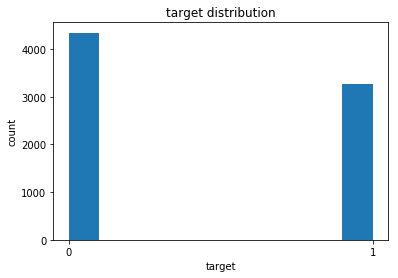

In [4]:
plt.hist(labels)
plt.xlabel('target')
plt.ylabel('count')
plt.title('target distribution')
plt.xticks(np.arange(len(np.unique(labels))));

### Prepare Data: Convert to tokens and add special tokens [CLS] and [SEP]

In [5]:
# add special tokens for BERT to work properly
sentences = ["[CLS] " + query + " [SEP]" for query in query_text]
print(sentences[1])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[1])

[CLS] Forest fire near La Ronge Sask. Canada [SEP]
Tokenize the first sentence:
['[CLS]', 'forest', 'fire', 'near', 'la', 'ron', '##ge', 'sas', '##k', '.', 'canada', '[SEP]']


### Prepare Data: Pad tokens to create sequences of constant length

In [6]:
# Maximum sequence length. 
MAX_LEN = 150

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


### Prepare Data
Create attention masks

In [7]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

### Split into train and validation datasets

In [8]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


### Convert data into torch tensors

In [9]:
# Convert data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### Create a data generator (iterator) for the train and validation data

In [10]:
batch_size = 32

# Create an iterator of train data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create an iterator of validation data with torch DataLoader 
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Load pretrained BERT model


In [11]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print (torch.cuda.get_device_name(0))

Tesla T4


In [12]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

num_labels = 2

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels=num_labels)
model.to(device)

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [13]:
if os.path.exists(model_path):
    print ("Loading weights from saved model...")
    model.load_state_dict(torch.load(model_path, map_location=device))


Loading weights from saved model...


### Model Train function

In [14]:
def train(model, iterator, optimizer):

    model.train()  

    epoch_loss = 0

    for step, batch in enumerate(iterator):
        
        #retrieve input data
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #resets the gradients after every batch
        optimizer.zero_grad()

        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # Backward pass
        loss.backward()
        
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        
        # loss
        epoch_loss += loss.item()

    
    return epoch_loss / len(iterator)

### Model Evaluate function

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Evaluate
def evaluate(model, iterator):
    
    #initialize every epoch
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    for batch in iterator:
        
        #retrieve input data
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #deactivates autograd
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        epoch_acc += tmp_eval_accuracy
        
    return epoch_acc / len(iterator)

### Train and Validate


In [16]:
N_EPOCHS = 3
best_valid_acc = 0

# BERT training loop
for _ in trange(N_EPOCHS, desc="Epoch"):  

    #train the model
    train_loss = train(model, train_dataloader, optimizer)
    
    #evaluate the model
    valid_acc = evaluate(model, validation_dataloader)
    
    #save the best model
    if valid_acc < best_valid_acc:
        best_valid_acc = valid_acc
        print ("saving model ...")
        torch.save(model.state_dict(), model_path)
    
    print(f'\t Train Loss: {train_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Epoch:  20%|██        | 1/5 [03:23<13:35, 203.99s/it]

	 Train Loss: 0.116 | Val. Acc: 82.11%


Epoch:  40%|████      | 2/5 [07:02<10:25, 208.41s/it]

	 Train Loss: 0.064 | Val. Acc: 82.15%


Epoch:  60%|██████    | 3/5 [10:47<07:06, 213.32s/it]

	 Train Loss: 0.046 | Val. Acc: 82.44%


Epoch:  80%|████████  | 4/5 [14:33<03:37, 217.03s/it]

	 Train Loss: 0.039 | Val. Acc: 83.77%


Epoch: 100%|██████████| 5/5 [18:18<00:00, 219.56s/it]

	 Train Loss: 0.031 | Val. Acc: 82.21%


### Predict

In [41]:
#load weights
model.to('cpu')
model.load_state_dict(torch.load(model_path))
model.eval()

#inference
def prepare_text(sentence, MAX_LEN = 150):
    sentence = "[CLS] " + sentence + " [SEP]"
    
    # Tokenize with BERT tokenizer
    tokenized_text = tokenizer.tokenize(sentence)
    
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    input_ids = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks

def predict(model, sentence):
    
    input_ids, attention_masks = prepare_text(sentence)
    
    prediction = model(input_ids, token_type_ids=None, attention_mask=attention_masks)    

    return prediction.detach().cpu().numpy()

def disaster_or_not(logits):
    pred = np.argmax(logits, axis=1)[0]
    return 'Disaster' if pred == 1 else 'Not a disaster'

In [42]:
logits = predict(model, "Forest fire near La Ronge Sask. Canada")
disaster_or_not(logits)

'Disaster'

In [44]:
logits = predict(model, "The weather is awesome")
disaster_or_not(logits)

'Not a disaster'